In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import shap
import lightgbm as lgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE





%matplotlib inline
%pylab inline


plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


# KPOP Group band ranking 2019

In [161]:
kpop_rank= pd.read_csv('C:/Users/aldoa/Desktop/dataset probstok chop-chop/kpop_rank.csv')
kpop_rank= kpop_rank.drop(kpop_rank.index[[1,10,11,12,13,14,18]]).reset_index().drop('index', 1)
kpop_rank= kpop_rank.set_index('artist_name')
kpop_rank

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov
artist_name,,,,,,,,,,,
BTS,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
BLACKPINK,3.0,2.0,2.0,2.0,2.0,2.0,2.0,5.0,6.0,5.0,3
Mamamoo,6.0,19.0,7.0,9.0,16.0,8.0,4.0,6.0,4.0,4.0,4
EXO,5.0,5.0,6.0,5.0,8.0,6.0,6.0,12.0,10.0,3.0,5
TWICE,4.0,4.0,9.0,4.0,3.0,8.0,5.0,2.0,2.0,8.0,6
Girls' Generation,16.0,12.0,14.0,11.0,20.0,12.0,10.0,8.0,8.0,7.0,7
Red Velvet,7.0,8.0,17.0,6.0,7.0,10.0,7.0,3.0,5.0,9.0,8
WINNER,13.0,21.0,26.0,22.0,12.0,26.0,15.0,26.0,27.0,17.0,9
NU'EST,23.0,9.0,12.0,16.0,5.0,5.0,17.0,27.0,28.0,12.0,10


Pada data diatas terdapat beberapa data group band KPOP yang memiliki banyak noise sehingga dilakukan drop data. Data yang tersisa adalah beberapa group band KPOP yang masuk kedalam 30 besar di tahun 2019. Data didapatkan dari Idol Group Brand Reputation setiap bulannya di www.soompi.com.

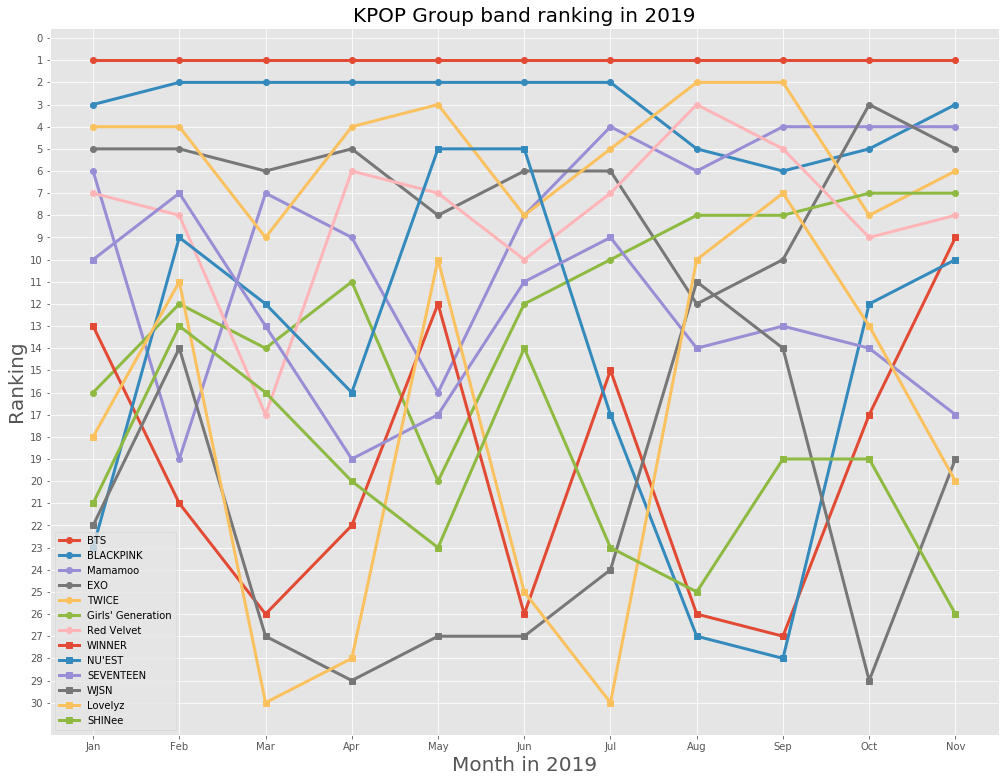

<Figure size 1224x936 with 0 Axes>

In [351]:
#visualisasi data rank KPOP
month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']
rank = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.plot(month, kpop_rank.loc['BTS'], 'o-', linewidth=3)
plt.plot(month, kpop_rank.loc['BLACKPINK'], 'o-', linewidth=3)
plt.plot(month, kpop_rank.loc['Mamamoo'], 'o-', linewidth=3)
plt.plot(month, kpop_rank.loc['EXO'], 'o-', linewidth=3)
plt.plot(month, kpop_rank.loc['TWICE'], 'o-', linewidth=3)
plt.plot(month, kpop_rank.loc['Girls\' Generation'], 'o-', linewidth=3)
plt.plot(month, kpop_rank.loc['Red Velvet'], 'o-', linewidth=3)
plt.plot(month, kpop_rank.loc['WINNER'], 's-', linewidth=3)
plt.plot(month, kpop_rank.loc['NU\'EST'], 's-', linewidth=3)
plt.plot(month, kpop_rank.loc['SEVENTEEN'], 's-', linewidth=3)
plt.plot(month, kpop_rank.loc['WJSN'], 's-', linewidth=3)
plt.plot(month, kpop_rank.loc['Lovelyz'], 's-', linewidth=3)
plt.plot(month, kpop_rank.loc['SHINee'], 's-', linewidth=3)
plt.title('KPOP Group band ranking in 2019', size=20)
plt.xlabel('Month in 2019', size=20)
plt.ylabel('Ranking', size=20)
plt.legend(['BTS','BLACKPINK','Mamamoo','EXO','TWICE','Girls\' Generation','Red Velvet',
            'WINNER','NU\'EST','SEVENTEEN','WJSN','Lovelyz','SHINee'])
plt.yticks(rank)
plt.gca().invert_yaxis()
plt.figure(figsize(17,13))
plt.show()

Dari grafik diatas semua group band KPOP mengalami perubahan ranking setiap bulannya di tahun 2019. Namun, hal tersebut berbeda untuk group band BTS yang ada di posisi pertama secara konstan. Ini merupakan awal dari analisa data yang akan kita lakukan yaitu untuk menemukan keunikan BTS hingga bisa ada di posisi teratas dalam industri musik KPOP.

# Audio Feature pada BTS

In [163]:
# import data audio feautre kpop
kpop_data = pd.read_csv('C:/Users/aldoa/Desktop/dataset probstok chop-chop/audio_feature.csv')
kpop_data= kpop_data.drop('no', axis= 1)
kpop_data.head()

,duration_ms,key,tempo,acousticness,danceability,instrumentalness,speechiness,valence,artist_name,release_date,song_name;
0,171023.0,9.0,86.622,0.0278,0.469,0.0,0.3420,0.652,BTS,2019-04-12,Intro : Persona;
1,229773.0,11.0,119.991,0.0923,0.645,0.0,0.0965,0.798,BTS,2019-04-12,Boy With Luv (feat. Halsey);
2,224225.0,8.0,174.039,0.1250,0.580,0.0,0.1140,0.475,BTS,2019-04-12,Mikrokosmos;
3,226321.0,7.0,105.766,0.0104,0.638,0.0,0.4440,0.261,BTS,2019-04-12,Make It Right;
4,234178.0,7.0,142.991,0.0142,0.633,0.0,0.0429,0.535,BTS,2019-04-12,HOME;


### Penjelasan audio feature:

<br/>**duration_ms**      = panjang track lagu dalam ms
<br/>**key**              = perkiraan dari keseluruhan nada yang ada pada lagu, nada C=0, C#=2, D=3....
<br/>**acousticness**     = unsur akustik pada track lagu tersebut, range 0-1
<br/>**danceability**     = kecocokan track lagu untuk digunakan berdansa, range 0-1
<br/>**instrumentalness** = unsur instrumental pada track lagu. Senandung "Ooh" atau "Aah" juga dinilai instrumental, range 0-1
<br/>**speechiness**      = Sebarapa banyak kata atau lyric pada lagu tersebut, range 0-1
<br/>**valence**          = kesan dari lagu antara bahagia dan sedih, range 0-1
<br/>**artist_name**      = nama group band KPOP
<br/>**relase_date**      = tanggal release lagu
<br/>**song_name**        = nama lagu

In [357]:
# mengelompokkan data sesuai dengan group band KPOP dengan mencari rata-rata setiap feature
# drop data juga dilakukan agar sesuai dengan data ranking group band KPOP 2019

kpop_data= kpop_data[kpop_data.artist_name != 'ASTRO']
kpop_data= kpop_data[kpop_data.artist_name != 'BIGBANG']
kpop_data= kpop_data[kpop_data.artist_name != '(G)I-DLE']
kpop_data= kpop_data[kpop_data.artist_name != 'HotShot']
kpop_data= kpop_data[kpop_data.artist_name != 'TOMORROW X TOGETHER']
kpop_data= kpop_data[kpop_data.artist_name != 'LADIES\' CODE']
kpop_data= kpop_data[kpop_data.artist_name != 'OH MY GIRL']
kpop_data.groupby('artist_name').agg({'acousticness':'mean','danceability':'mean','instrumentalness':'mean','speechiness':'mean','valence':'mean'}).sort_values('danceability', ascending = False)

,acousticness,danceability,instrumentalness,speechiness,valence
artist_name,,,,,
TWICE,0.167135,0.700487,0.020693,0.078254,0.636710
WJSN,0.169243,0.687250,0.010699,0.077481,0.645953
SEVENTEEN,0.202830,0.684743,0.008825,0.115452,0.651923
Girls' Generation,0.190259,0.680504,0.058523,0.078300,0.658268
Mamamoo,0.362007,0.670450,0.063157,0.093627,0.569975
BLACKPINK,0.126922,0.666465,0.015314,0.078334,0.515385
Red Velvet,0.250939,0.655857,0.011204,0.097873,0.608840
SHINee,0.147297,0.645162,0.012587,0.082585,0.588089
Lovelyz,0.235739,0.642667,0.296743,0.058203,0.575513


Tabel diatas didapatkan dengan mencari rata-rata feature dari seluruh track yang ada pada seluruh album setiap group band kpop sehingga menghasilkan data yang bisa menjadi representasi dari audio feature setiap group band KPOP. Data diatas diurutkan dari yang memiliki nilai speechiness paling tinggi ke paling rendah dan ternyata BTS ada di posisi pertama yang artinya track lagu yang dinyanyikan oleh group band satu ini memiliki komponen kata atau lyric yang dominan lebih banyak dibandingkan group band lainnya. Untuk lebih jelasnya setiap komponen audio feature BTS diatas akan kita analisa lebih lanjut.

Text(0.5, 0.98, 'Histogram fitur-fitur yang ada pada track BTS')

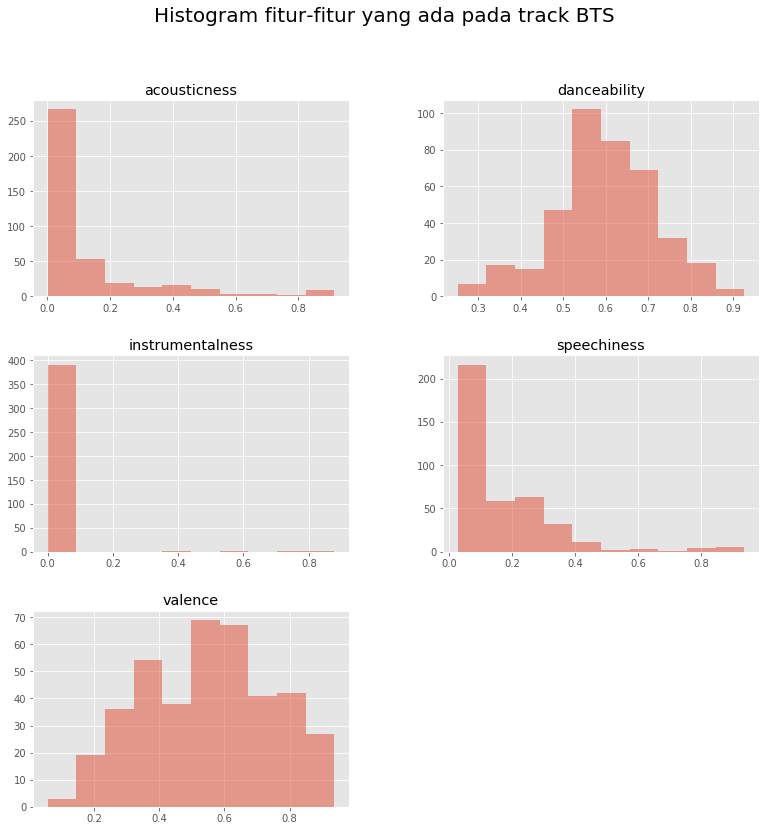

In [165]:
# Visualisasi fitur-fitur yang dimiliki BTS sebagai group band KPOP ranking 1 sepanjang tahun 2019
figure = figsize(13,13)
bts_data= kpop_data.drop(['duration_ms', 'key', 'tempo'], axis=1)
bts_data[bts_data.artist_name == 'BTS']._get_numeric_data().hist(alpha = 0.5)
suptitle('Histogram fitur-fitur yang ada pada track BTS', size = 20)

Histogram diatas adalah visualisasi dari audio feature yang dimiliki oleh group band BTS. Kita bisa melihat dari distribusi datanya untuk setiap audio feature:

<br/>**acousticness**, track lagu BTS sangat sedikit bersifat atau mengandung unsur dari alat musik akustik
<br/>**danceability**, track lagu BTS secara keseluruhan cukup cocok untuk untuk digunakan menari.
<br/>**instrumentalness**, track lagu BTS juga sedikit mengandung unsur instrumental.
<br/>**speechiness**, track lagu BTS memiliki lyric yang lebih banyak bila dibandingkan dengan group band KPOP lainya.
<br/>**valence**, track lagu BTS juga seimbang dalam hal valence yaitu tidak semua lagunya berkesan bahagia namun juga ada yang sedih.

# Perbedaan antara BTS dan Group Band KPOP lainnya

In [166]:
# Selain kelima audio feature yang dimiliki BTS kita akan mencari perbedaan antara BTS dengan 2 grup dibawahnya
# BTS akan dibandingkan dengan girl band dan boy band yang peringkatnya dibawah yaitu BLACKPINK dan EXO
bts_key = kpop_data[kpop_data['artist_name'] == 'BTS']['key']  
bts_tempo = kpop_data[kpop_data['artist_name'] == 'BTS']['tempo']
blackpink_key = kpop_data[kpop_data['artist_name'] == 'BLACKPINK']['key']
blackpink_tempo = kpop_data[kpop_data['artist_name'] == 'BLACKPINK']['tempo']
exo_key = kpop_data[kpop_data['artist_name'] == 'EXO']['key']
exo_tempo = kpop_data[kpop_data['artist_name'] == 'EXO']['tempo']

Komponen yang dibandingkan adalah tempo dan key pada track lagu karena kompononen tersebut merupakan komponen yang digunakan algoritma Spotify API untuk menentukan fitur-fitur lainya pada track lagu seperti danceability, speechiness, dll.

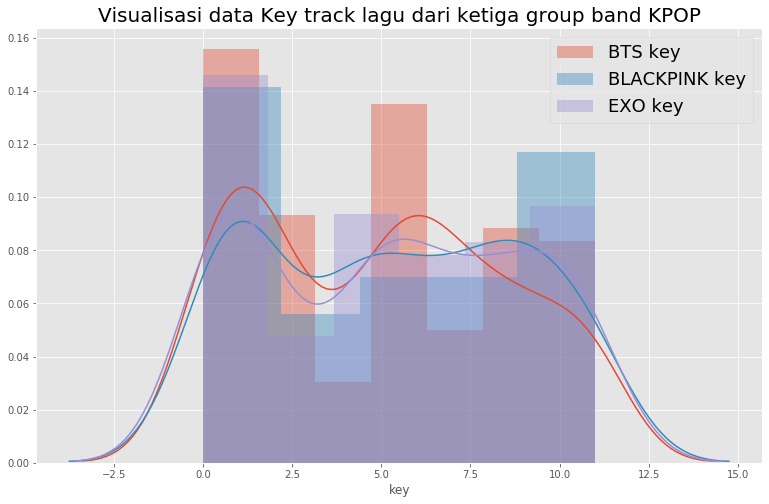

In [355]:
figure = figsize(13,8)
sns.distplot(bts_key, label = 'BTS key')
sns.distplot(blackpink_key, label = 'BLACKPINK key')
sns.distplot(exo_key, label = 'EXO key')
title('Visualisasi data Key track lagu dari ketiga group band KPOP', size = 20)
plt.legend(prop = {'size': 18})

Pada grafik diatas dapat dilihat key track lagu pada BTS terpusat pada key F dan persebesaran nada minor dan mayornya sama, terdapat persebaran yang merata pada track lagu EXO, dan pada track lagu Blackpink  memiliki nada yang cenderung lebih tinggi diantara keduanya.

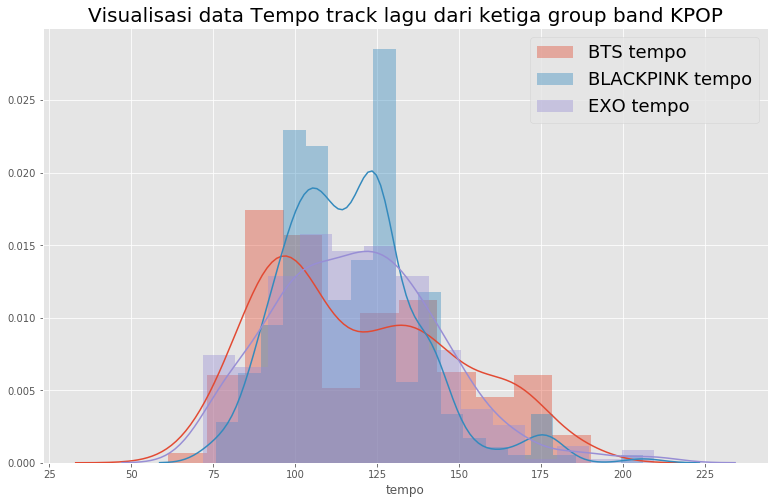

In [356]:
figure = figsize(13,8)
sns.distplot(bts_tempo, label = 'BTS tempo')
sns.distplot(blackpink_tempo, label = 'BLACKPINK tempo')
sns.distplot(exo_tempo, label = 'EXO tempo')
title('Visualisasi data Tempo track lagu dari ketiga group band KPOP', size = 20)
plt.legend(prop = {'size': 18})

Dari grafik diatas, tempo pada track lagu EXO dominan ada disekitar 100 BPM, tempo track lagu Blackpink pada 125 BPM, dan tempo pada track lagu BTS lebih terdistribusi.

# Fitur penting sebagai rank 1 KPOP dengan standar BTS

In [304]:
# Mencari fitur yang penting untuk menjadi group band KPOP no 1 dengan BTS sebagai standarnya
kpop_sample= kpop_data
kpop_sample['target'] = [1 if i == 'BTS' else 0 for i in kpop_sample.artist_name]
kpop_sample= kpop_data.drop(['artist_name','release_date','song_name;','duration_ms'], axis=1)

In [335]:
X_train, X_validation, y_train, y_validation = train_test_split(kpop_sample.iloc[:,:-1], kpop_sample.target, train_size=0.2)

X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

X_train_lgbm = X_train_lgbm.fillna(X_train_lgbm.mean())
X_validation_lgbm = X_validation_lgbm.fillna(X_train_lgbm.mean())

X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

In [336]:
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_sample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('index')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('index')

In [314]:
lgb_c = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
lgb_c.fit(X_train_smote, y_train_smote,
           eval_set=[(X_validation_smote, y_validation_smote)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=200,)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.856004	valid_0's binary_logloss: 0.505915
Early stopping, best iteration is:
[290]	valid_0's auc: 0.87701	valid_0's binary_logloss: 0.494008


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=50,
               reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

In [337]:
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
gbc.fit(X_train_smote, y_train_smote)

validation_pred_proba_grad = gbc.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1]

SyntaxError: unexpected EOF while parsing (<ipython-input-337-bb795b4c9255>, line 5)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


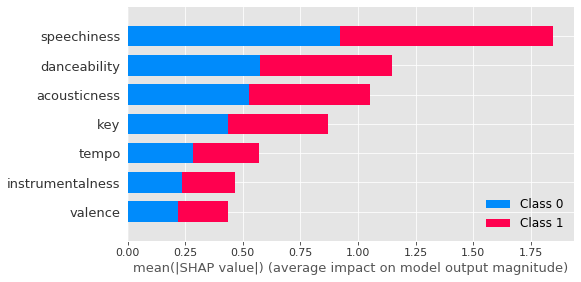

In [338]:
shap_values = shap.TreeExplainer(lgb_c).shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

Dari metode SHAP value dan lightGBM diatas, diketetahui fitur audio penting yang menjadi ciri khas BTS sebagai group band rank 1 di tahun 2019 adalah speechiness lalu danceability dan seterusnya. Bila menjadikan BTS sebagai standar maka seharusnya banyak group yang memiliki kesempatan karena pada fitur danceability yang menjadi fitur penting kedua pada group band BTS justru memiliki nilai lebih kecil dibawah group band lainnya. Sekarang kita akan mencoba menganalisa ranking group band KPOP secara kesuluruhan.

# Analisa ranking group band KPOP di tahun 2019

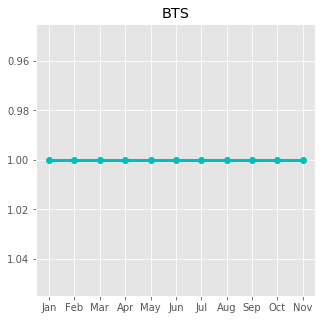

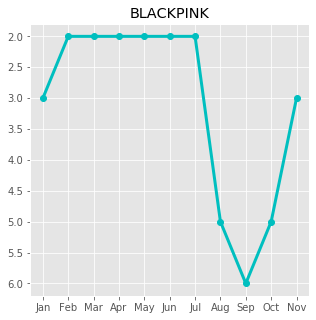

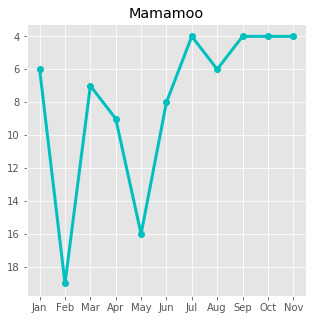

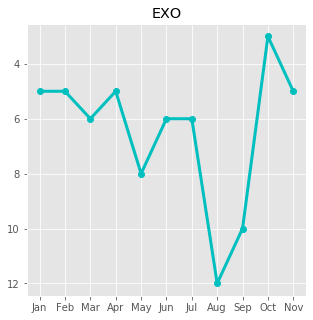

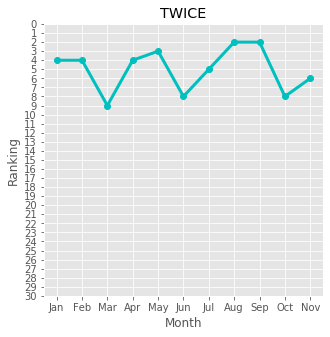

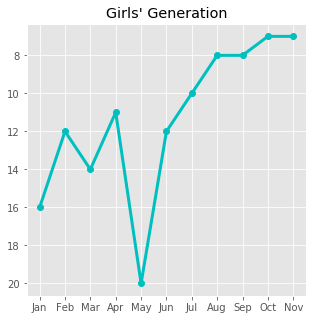

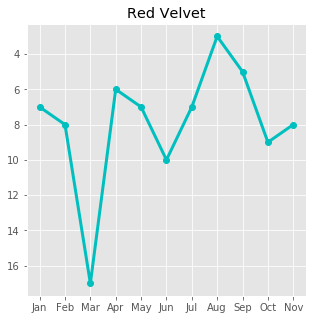

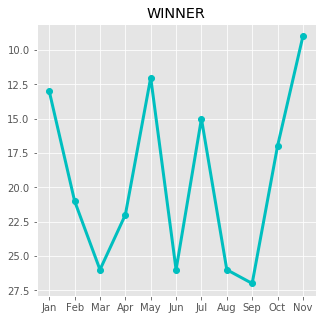

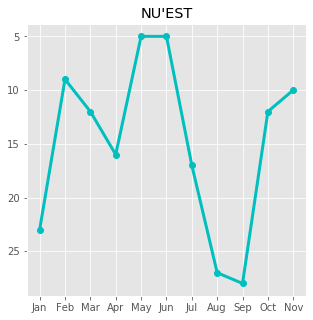

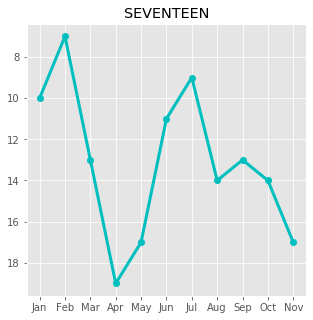

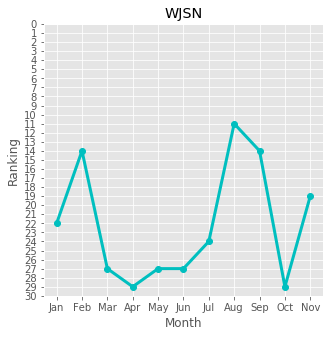

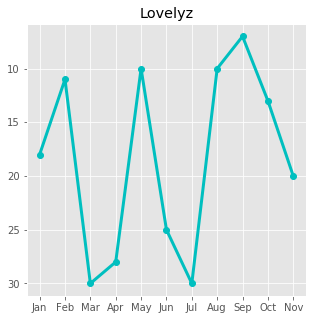

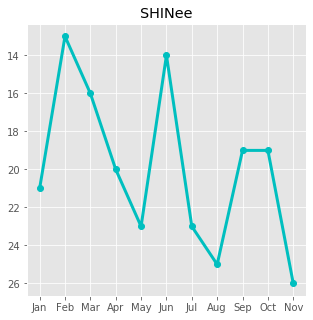

<Figure size 360x360 with 0 Axes>

In [361]:
# Cek perubahan ranking diantara group band KPOP di tahun 2019
#visualisasi data rank KPOP
plt.figure(1)
plt.plot(month, kpop_rank.loc['BTS'], 'co-', linewidth=3)
plt.title('BTS')
plt.gca().invert_yaxis()
plt.figure(2)
plt.plot(month, kpop_rank.loc['BLACKPINK'], 'co-', linewidth=3)
plt.title('BLACKPINK')
plt.gca().invert_yaxis()
plt.figure(3)
plt.plot(month, kpop_rank.loc['Mamamoo'], 'co-', linewidth=3)
plt.title('Mamamoo')
plt.gca().invert_yaxis()
plt.figure(4)
plt.plot(month, kpop_rank.loc['EXO'], 'co-', linewidth=3)
plt.title('EXO')
plt.gca().invert_yaxis()
plt.figure(5)
plt.plot(month, kpop_rank.loc['TWICE'], 'co-', linewidth=3)
plt.yticks(rank)
plt.ylabel('Ranking')
plt.xlabel('Month')
plt.title('TWICE')
plt.gca().invert_yaxis()
plt.figure(6)
plt.plot(month, kpop_rank.loc['Girls\' Generation'], 'co-', linewidth=3)
plt.title('Girls\' Generation')
plt.gca().invert_yaxis()
plt.figure(7)
plt.plot(month, kpop_rank.loc['Red Velvet'], 'co-', linewidth=3)
plt.title('Red Velvet')
plt.gca().invert_yaxis()
plt.figure(8)
plt.plot(month, kpop_rank.loc['WINNER'], 'co-', linewidth=3)
plt.title('WINNER')
plt.gca().invert_yaxis()
plt.figure(9)
plt.plot(month, kpop_rank.loc['NU\'EST'], 'co-', linewidth=3)
plt.title('NU\'EST')
plt.gca().invert_yaxis()
plt.figure(10)
plt.plot(month, kpop_rank.loc['SEVENTEEN'], 'co-', linewidth=3)
plt.title('SEVENTEEN')
plt.gca().invert_yaxis()
plt.figure(11)
plt.plot(month, kpop_rank.loc['WJSN'], 'co-', linewidth=3)
plt.title('WJSN')
plt.yticks(rank)
plt.ylabel('Ranking')
plt.xlabel('Month')
plt.gca().invert_yaxis()
plt.figure(12)
plt.plot(month, kpop_rank.loc['Lovelyz'], 'co-', linewidth=3)
plt.title('Lovelyz')
plt.gca().invert_yaxis()
plt.figure(13)
plt.plot(month, kpop_rank.loc['SHINee'], 'co-', linewidth=3)
plt.title('SHINee')
plt.gca().invert_yaxis()
plt.figure(figsize(5,5))
plt.show()

Dengan memisahkan grafik ranking masing-masing group band KPOP dapat dilihat perubahan ranking group band setiap bulannya di tahun 2019.

In [278]:
# Menggabungkan grafik ranking suatu group KPOP dengan bulan realease lagu (comeback)
# Analisa menggunakan grafik ranking group band WJSN karena mengalami kenaikan dan penurunan ranking pada tahun 2019 secara berkala
kpop_sample2 = kpop_data.drop(['duration_ms','target','key','tempo','acousticness','danceability','instrumentalness',
                               'speechiness','valence'], axis=1).set_index('artist_name')
var = kpop_sample2.loc['WJSN'].reset_index()
comeback = pd.DataFrame(NaN,index=['WJSN','TWICE'],columns= month)

if '2019-01' in str(var.release_date):
        comeback.Jan['WJSN'] = 1
if '2019-02' in str(var.release_date):
        comeback.Feb['WJSN'] = 1
if '2019-03' in str(var.release_date):
        comeback.Mar['WJSN'] = 1
if '2019-04' in str(var.release_date):
        comeback.Apr['WJSN'] = 1
if '2019-05' in str(var.release_date):
        comeback.May['WJSN'] = 1
if '2019-06' in str(var.release_date):
        comeback.Jun['WJSN'] = 1
if '2019-07' in str(var.release_date):
        comeback.Jul['WJSN'] = 1
if '2019-08' in str(var.release_date):
        comeback.Aug['WJSN'] = 1
if '2019-09' in str(var.release_date):
        comeback.Sep['WJSN'] = 1
if '2019-10' in str(var.release_date):
        comeback.Oct['WJSN'] = 1
if '2019-11' in str(var.release_date):
        comeback.Nov['WJSN'] = 1
if '2019-12' in str(var.release_date):
        comeback.Dec['WJSN'] = 1        

<function matplotlib.pyplot.show(*args, **kw)>

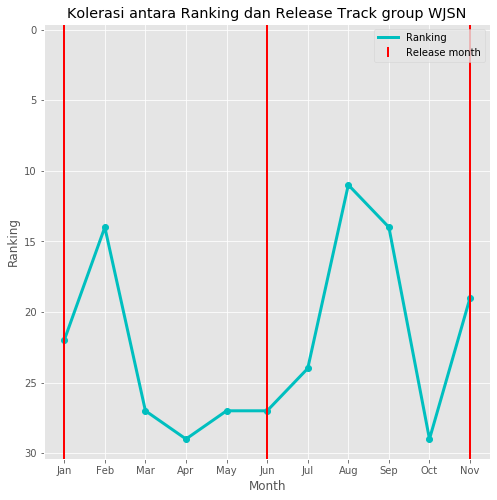

<Figure size 576x576 with 0 Axes>

In [268]:
# Visualisasi data ranking dan release track/album group band WJSN

plt.plot(month, kpop_rank.loc['WJSN'], 'co-', linewidth=3)
plt.plot(month, comeback.loc['WJSN'], 'r|', ms=1000, mew=2)
plt.legend(['Ranking','Release month'], markerscale=0.01, loc=1)
plt.gca().invert_yaxis()
plt.ylabel('Ranking')
plt.xlabel('Month')
plt.title('Kolerasi antara Ranking dan Release Track group WJSN')
plt.figure(figsize(8,8))
plt.show

Dapat dilihat dari grafik diatas pada saat group band WJSN comeback (release track/album baru), WJSN tidak mengalami penurunan peringkat dibulan tersebut ataupun satu bulan sesudahnya bahkan ranking-nya semakin meningkat setelah comeback dibulan Januari dan Juni.

In [279]:
# Analisa pengaruh comeback pada ranking di group band KPOP lainya

var = kpop_sample2.loc['TWICE'].reset_index()
if '2019-01' in str(var.release_date):
        comeback.Jan['TWICE'] = 1
if '2019-02' in str(var.release_date):
        comeback.Feb['TWICE'] = 1
if '2019-03' in str(var.release_date):
        comeback.Mar['TWICE'] = 1
if '2019-04' in str(var.release_date):
        comeback.Apr['TWICE'] = 1
if '2019-05' in str(var.release_date):
        comeback.May['TWICE'] = 1
if '2019-06' in str(var.release_date):
        comeback.Jun['TWICE'] = 1
if '2019-07' in str(var.release_date):
        comeback.Jul['TWICE'] = 1
if '2019-08' in str(var.release_date):
        comeback.Aug['TWICE'] = 1
if '2019-09' in str(var.release_date):
        comeback.Sep['TWICE'] = 1
if '2019-10' in str(var.release_date):
        comeback.Oct['TWICE'] = 1
if '2019-11' in str(var.release_date):
        comeback.Nov['TWICE'] = 1
if '2019-12' in str(var.release_date):
        comeback.Dec['TWICE'] = 1

<function matplotlib.pyplot.show(*args, **kw)>

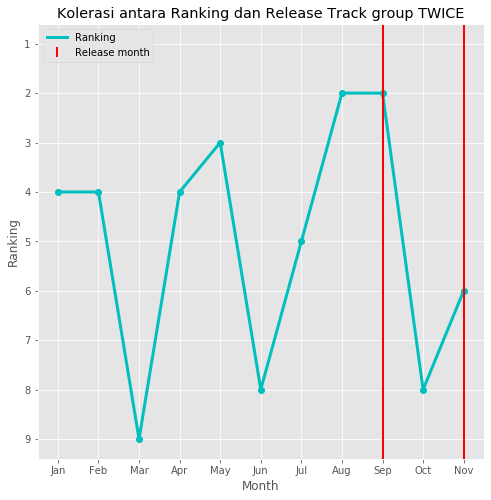

<Figure size 576x576 with 0 Axes>

In [280]:
# Visualisasi data ranking dan release track/album group band TWICE

plt.plot(month, kpop_rank.loc['TWICE'], 'co-', linewidth=3)
plt.plot(month, comeback.loc['TWICE'], 'r|', ms=1000, mew=2)
plt.legend(['Ranking','Release month'], markerscale=0.01)
plt.gca().invert_yaxis()
plt.ylabel('Ranking')
plt.xlabel('Month')
plt.title('Kolerasi antara Ranking dan Release Track group TWICE')
plt.figure(figsize(8,8))
plt.show

Dari grafik diatas dapat dilihat pengaruh comeback pada group band TWICE dibulan September justru membuat group girl KPOP satu ini turun rank. Namun, saat comeback di bulan November group band ini berhasil menaikkan ranking-nya kembali.<br/>

Dari sini dapat diketahui bahwa pengaruh comeback tidak sepenuhnya langsung terjadi pada setiap group band KPOP namun dari beberapa group KPOP yang telah dianalisa setidaknya setelah melakukan comeback group band KPOP tersebut bisa mempertahankan atau meningkatkan peringkatnya.